In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dateutil.relativedelta import relativedelta
from matplotlib import rcParams



import numpy as np
import dateutil.parser as dparser
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean

# from mpl_toolkits.basemap import Basemap (rotate, ben's suggestion)



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')
rcParams.update({'figure.autolayout': True})

In [2]:
test = True


Iona = (-123.30807, 49.19026) #value from first point in traj.txt (Ariane output)

S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)
xl=(-126.2,-122.2)
yl=(47.1,51)

cmap_p = mpl.cm.get_cmap('Oranges')
cmap_w = cmocean.cm.dense_r

RAWDIR = "/ocean/gsgarbi/ariane_raw/2016+jan2017/"

H = 24

pph = 3

ppd = H * pph #(also number of outputs per trajectory per day since we have 3 outputs per hour

In [6]:
def find_direct (RAWDIR, date, traj_len):
    'traj len needs to be less than 30 (days)'
    start = date
    end = date + dt.timedelta(days = traj_len) 
    y = str(start.year)
    m = str(start.month)
    n = str(end.month)
    w = str(end.year)
    


    if len (m) == 1:
        m = "0"+str(m)
        
    if len (n) == 1:
        n = "0"+str(n)
    
    direct = [ i for i in os.listdir(RAWDIR) if y+m == i[:6] or w+n == i[:6] ]
    
    direct = sorted(direct)
    
    print ("got directory(ies)")
    
    return direct
    
def get_points(direct, init_date, traj_len, phase = 0):
    '''
    get 72 trajs (3 per hour) starting on date.day with fixed traj len
    '''
    
    date0 = dt.datetime( init_date.year, init_date.month, 1, 0, 0)
    
    phase = phase * 3
    pts = []

    d = init_date.day
    #select the particles
    parts = range (1 + ppd*(d - 1) + phase, 1 + ppd*(d - 1) + phase + 72)

    part = parts[0]
    

    
    

    
    for directory in direct:


        with open(RAWDIR + directory + "/traj.txt") as file:
            
            

            count = 0
            traj = []
            
            date0 += relativedelta( months = direct.index(directory) )

            
            
            for i, line in enumerate(file):

                line = line.strip('\n').split()
                line = [float(k) for k in line]


                if line[0] == part:
                    

                    
                    mins0 = 60*int( (part-1)/3 )
                    
                    time = date0 + dt.timedelta( minutes = mins0) + dt.timedelta( minutes = count * 20)
                    
                    
                    traj.append(line + [time])
                    

                    count +=1
                if count == traj_len * ppd:

                    pts.append(traj)
                    traj = [] #reset traj
                    count = 0 #reset counter
                    part += 1 #go to the next particle

                if part == parts[-1]+1:
                    break
            else:
                    print ("month transition -> open next file")
                    


                    parts = range (1, parts[-1] - part)
                    part = parts[0]

               
    return pts

def close(p, q = S15, distance = 0.5):
    d = geo_tools.haversine (p[0],p[1], q[0], q[1])
 #   print ("The distance is {}".format(d))
    if d.all() < distance:

        return True
    else:

        return False
    
def dist(p, q = S15):
    d = geo_tools.haversine (p[1],p[2], q[0], q[1])
    return d

def min_dist_traj(traj, q = S15):
    ds = [geo_tools.haversine (p[1],p[2], q[0], q[1]) for p in traj]
    return min (ds)

def traj_analysis (traj, time = 24, distance = 1.2):
    '''output : time series w start date. out 1: boolean if in the region within time T and distance D (arguments + traj). output2: the age it first enters the region (0 it doesnt). then run for a few days. 
    then run for june, august, july, sept. 
    plot a time series with 0 and 1 from output 1.'''
    
    check = 0
    
    age = 0
    
    for pt in traj:


        if (dist(pt, S15) < distance or dist(pt, S16) < distance) and traj.index(pt)/3 < time:
            check = 1
            age = traj.index(pt)/3
            break
    return (check, age)

In [4]:
time0 = dt.datetime(2016, 6, 1)

In [13]:
pts = []

traj_len = 1

times = np.array(
    [
    dt.datetime(2016, 7, 19),
    dt.datetime(2016, 7, 26),
    dt.datetime(2016, 8, 2),
    dt.datetime(2016, 8, 9),
    dt.datetime(2016, 8, 16),
    dt.datetime(2016, 8, 23),
    ]
                            )
north = [dt.datetime(2016, 7, 26), dt.datetime(2016, 8, 23)]


test = np.array(
    [
    dt.datetime(2016, 7, 19),
    dt.datetime(2016, 7, 26)
    ]
)

time0 = dt.datetime(2016, 6, 1)

date = time0

while date != dt.datetime(2016, 6, 3):
    
    direct = find_direct(RAWDIR, date, traj_len)
    
    pts.append(get_points(direct, date, traj_len, phase = 0))
    
    date = date + dt.timedelta (days = 1)
    
full_period = [k for sublist in pts for k in sublist]

got directory(ies)
got directory(ies)


In [14]:
results = []

for traj in full_period:
    results.append(traj_analysis(traj))
results = np.array(results)

the age at which the particles are in the (0,500) m range. first point that crosses within the radius => age

output : time series w start date. out 1: boolean if in the region within time T and distance D (arguments + traj). output2: the age it first enters the region (0 it doesnt). then run for a few days. then run for june, august, july, sept. plot a time series with 0 and 1 from output 1.

discussion: correlations between those things (0 and 1 times series, winds and *tides*)

In [15]:
def plot_ts (results, init_date = dt.datetime(2016, 6, 1) ):
    fig, axs = plt.subplots(1,1, figsize = (9,8))
    
    days = [int(k/72) for k in range (len(results))]
    
    xaxis = [init_date + dt.timedelta(days = i) for i in days]
    
    faxis = [(k.day)  for k in xaxis]
    
    axs.plot( xaxis, results[:,1], 'bo'  )
    axs.set_xlabel("Date")
    
    axs.set_ylabel('Crossing time')
    
    plt.tight_layout()
        

/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


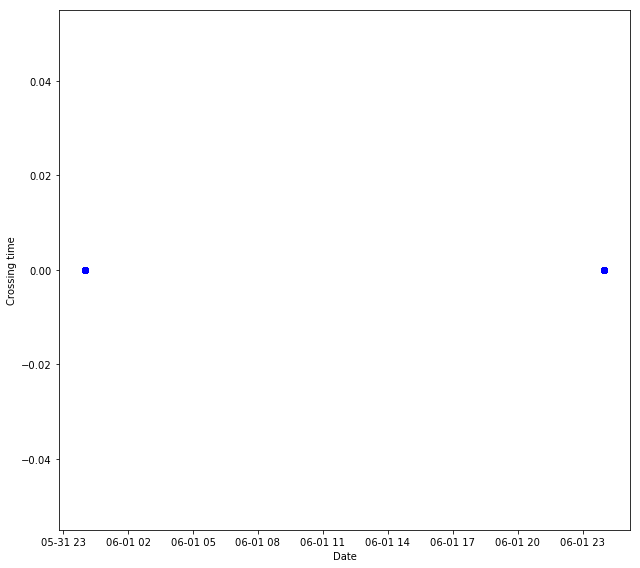

In [16]:
plot_ts(results)